In [1]:
#matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

---
# Clustering

In [2]:
from sklearn.datasets import make_blobs
# generates groups of points arount a given number of centers
# blobs are the data, y are the labels 
blobs, y = make_blobs(n_samples=1500,
                      n_features=5,
                      centers=5,
                      cluster_std=4,
                      random_state=799)

print('Dataset shape:', blobs.shape)
for label in np.unique(y):
    print(f'Num labels equals to {label} =', sum(y == label))

Dataset shape: (1500, 5)
Num labels equals to 0 = 300
Num labels equals to 1 = 300
Num labels equals to 2 = 300
Num labels equals to 3 = 300
Num labels equals to 4 = 300


In [16]:
from sklearn.manifold import TSNE
# use t-SNE to reduce the dimension to 2. The projected data will be used just for visualization,
# the clustering will be done on the original data 'blobs', in R^5
projected = TSNE(
    n_components=2, 
    init='pca',
    verbose=0, 
    perplexity=30, 
    random_state=12345
).fit_transform(blobs)

In [17]:
def plot_compare(x, y, y_pred, title):
    """ Helper """
    # the position (x0, x1) of the points are the projected data
    # the colors are the original labels or the labels of the cluster algorithm
    plt.figure(figsize=(14, 6))
    #define a table with 1 row, two columns, and plot the next scatter in column 1
    plt.subplot(121)
    # plots the predicted values (colord)
    plt.scatter(x[:, 0], x[:, 1],
                c=y_pred, 
                edgecolor='black', 
                alpha=0.8,
                cmap='Accent')
    plt.title(title)
    plt.xlabel('component 1')
    plt.ylabel('component 2');

    #define a table with 1 row, two columns, and plot the next scatter in column 2
    plt.subplot(122)
    # plots the original labels (colors)
    plt.scatter(x[:, 0], x[:, 1],
                c=y, 
                edgecolor='black', 
                alpha=0.8,
                cmap='Accent')
    plt.title('True clusters')
    plt.xlabel('component 1')
    plt.ylabel('component 2');

----
## K-means

In [5]:
from sklearn.cluster import KMeans
#help(KMeans)

In [6]:
kmeans = KMeans(n_clusters=5,
                max_iter=500,
                verbose=0).fit(blobs)

print(f'Inertia = {kmeans.inertia_:.5f}')

Inertia = 120856.32770


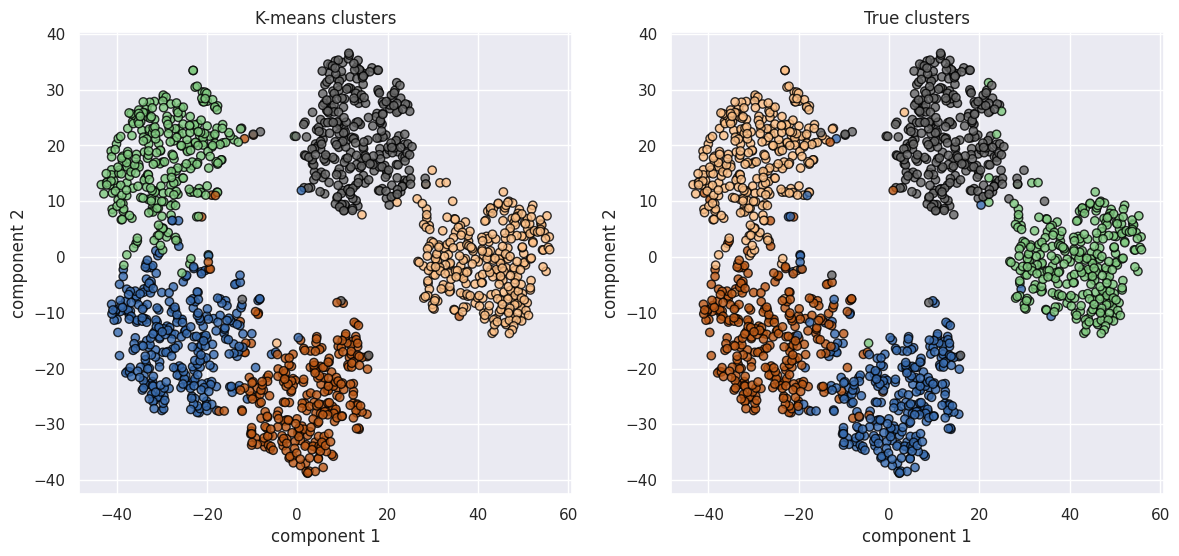

In [18]:
plot_compare(projected, y, kmeans.labels_, 'K-means clusters')

In [19]:
def find_wrong(labels, y):
    """
    
    Args:
        :param labels: labels given by the clustering algorithm.
        :param y: true labels.
    """
    mapped_labels = labels.copy()
    mapped_labels2 = labels.copy()
    for alg_label in np.unique(labels):
        # finds the true values associated to the value 'alg_label' given by the algorith,
        vals, counts = np.unique(y[labels == alg_label], return_counts=True)
        # we select as correct label the most frequent one, 
        # by supposing that the clustering algorithm make some error, but not so many
        correct_cluster = vals[np.argmax(counts)]
        # we give the correct label to all the elements with value alg_label 
        mapped_labels[labels == alg_label] = correct_cluster
    return y != mapped_labels

Number of wrong points 59/1500


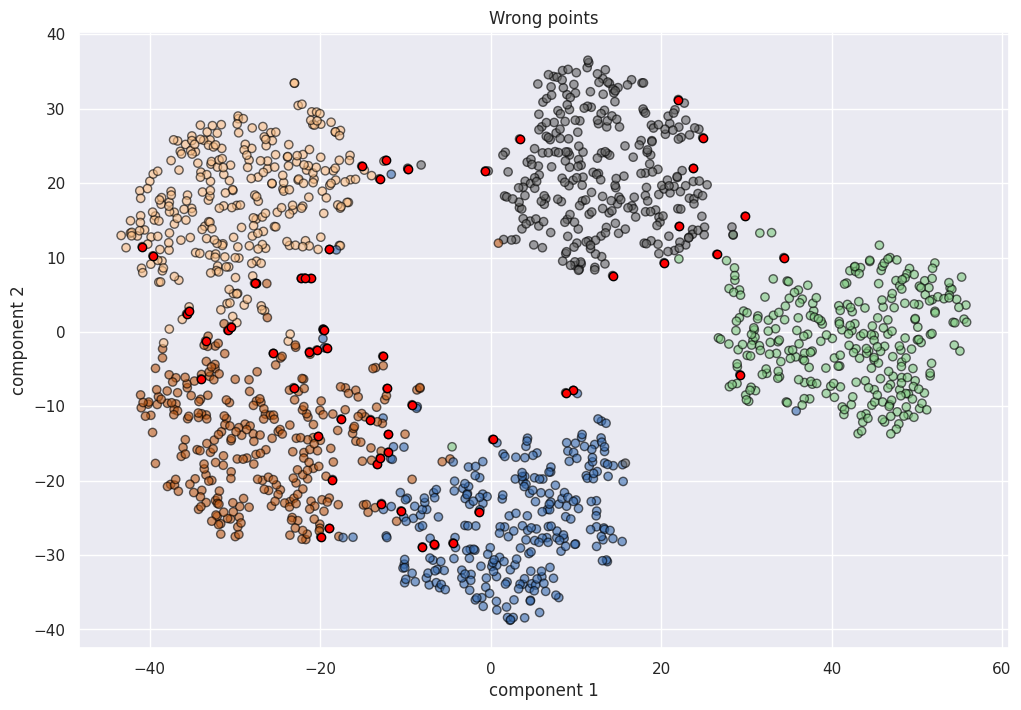

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, 
            edgecolor='black', 
            alpha=0.6,
            cmap='Accent')

wrong = find_wrong(kmeans.labels_, y)
print(f'Number of wrong points {sum(wrong)}/{len(y)}')
plt.scatter(projected[wrong, 0], projected[wrong, 1],
            c='red', 
            edgecolor='black', 
            alpha=1)

plt.title('Wrong points')
plt.xlabel('component 1')
plt.ylabel('component 2');

In [21]:
random_state = 12345

### How many clusters?

The number of clusters is an input parameter to the k-means algorithm. 
To select the best value we can perform several experiments using a structured method as the  **elbow method**. <br>

In this method you have to run several k-means by incrementing k with each iteration.
At the end of each iteration you have to record (and plot) the intertia.<br>

There’s a sweet spot where the Inertia curve starts to bend known as the **elbow point**. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters.

In [10]:
inertias = []
clusters = []
# try from 2 to 9 clusters
for num_clusters in range(2, 10):
    kmeans_ = KMeans(n_clusters=num_clusters, 
                     max_iter=500, 
                     verbose=0, 
                     random_state=12345).fit(blobs)
    inertias.append(kmeans_.inertia_)
    clusters.append(num_clusters)

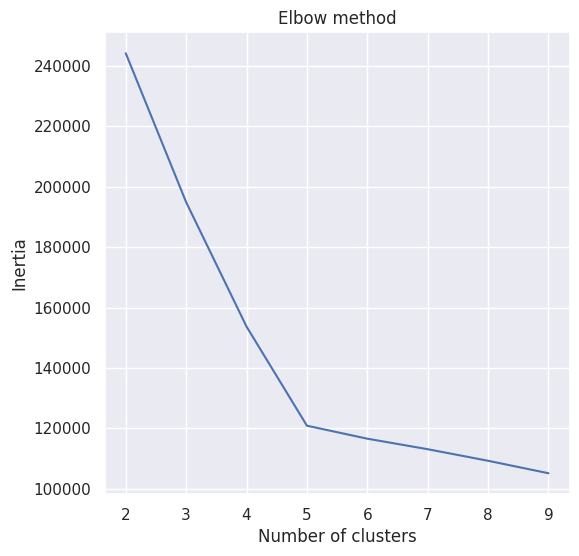

In [11]:
plt.figure(figsize=(6, 6))
plt.plot(clusters, inertias)

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method');

In this case 5 seems to be a good value 

---
## Agglomerative

In [12]:
from sklearn.cluster import AgglomerativeClustering
#help(AgglomerativeClustering)

In [30]:
agglo = AgglomerativeClustering(
    metric='euclidean',
    linkage='ward',
    #distance_threshold=0.0001, n_clusters=None
    n_clusters=5
)

y_pred = agglo.fit_predict(blobs)

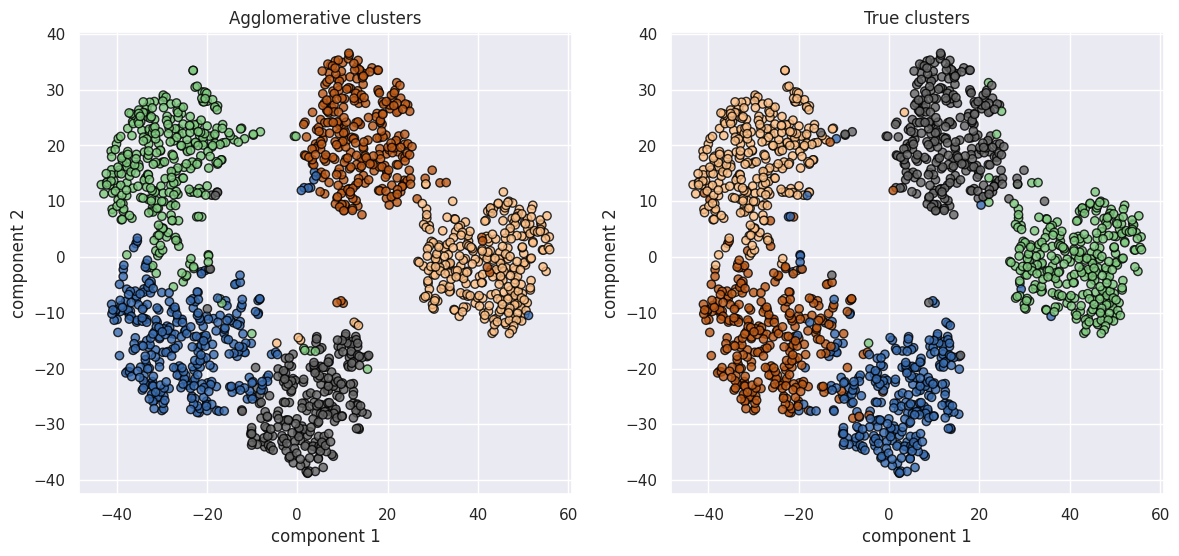

In [31]:
plot_compare(projected, y, y_pred, 'Agglomerative clusters')

In [23]:
y_pred

array([2, 2, 1, ..., 1, 2, 0], shape=(1500,))

Number of wrong points 127/1500


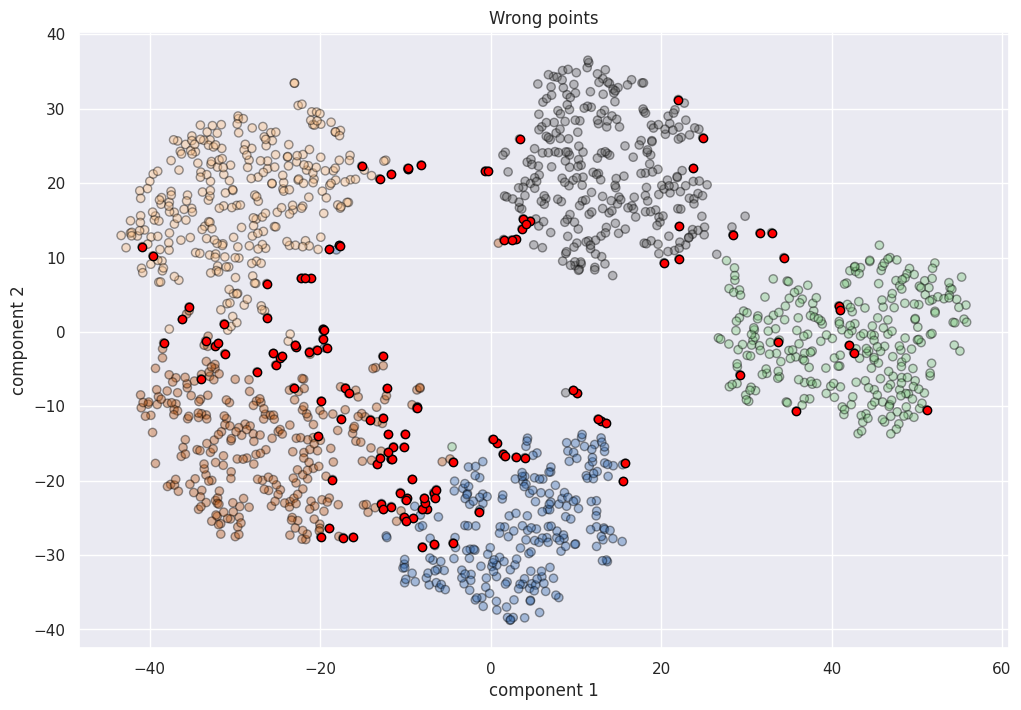

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, 
            edgecolor='black', 
            alpha=0.4,
            cmap='Accent')

wrong = find_wrong(y_pred, y)
print(f'Number of wrong points {sum(wrong)}/{len(y)}')
plt.scatter(projected[wrong, 0], projected[wrong, 1],
            c='red', 
            edgecolor='black', 
            alpha=1)

plt.title('Wrong points')
plt.xlabel('component 1')
plt.ylabel('component 2');

---
## Ex: compare the effect of different linkage metrics

Use different linkage metrics and see what happen to the clusters.

In [25]:
from sklearn.datasets import make_circles

x_circles, y_circles = make_circles(n_samples=1500, 
                                    factor=0.5, 
                                    noise=0.05)